In [1]:
def preprocess(user_id, items) :
    state = [[user_id]]
    for item in items :
        as_category = item.get_as_one_hot()
        state.append(as_category[0])  # Id
        state.append([as_category[1]])  # Price
        state.append(as_category[2])  # Color
    flat = itertools.chain.from_iterable(state)
    return list(flat)


def replay(modele, target, memory, optimizer) :
    states, actions, next_states, rewards, dones = modele.sample(batch_size, memory)
    states = process_states(states)
    next_states = process_states(next_states)
    rewards = rewards.reshape((-1, 1))
    dones = dones.reshape((-1, 1))

    prediction = torch.tensor(
        (1 - dones) * (rewards + modele.gamma * np.amax(target(next_states).detach().numpy(), axis = 1)))

    real_value = modele(states)
    prediction = prediction.view(-1, 1)
    actions = actions.view(-1, 1)  # 32, 1
    pre = real_value.clone()
    for cpt, row in enumerate(real_value) :
        row[actions[cpt]] = prediction[cpt].float()
        real_value[cpt] = row

    loss = F.mse_loss(pre, real_value)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def process_states(batch_states) :
    batch = []
    for states in batch_states :
        sub_batch = []
        user_id = states[0]
        for items in states[1] :
            sub_batch.append(preprocess(user_id, [items]))
        batch.append(sub_batch)
    return batch
import os
import torch
os.chdir("/Users/benjaminangelard/Thesis_Recommender_system")


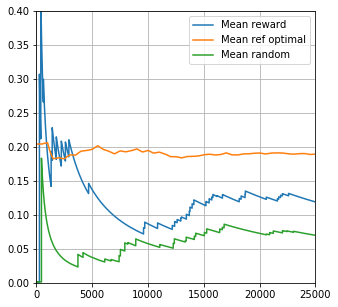

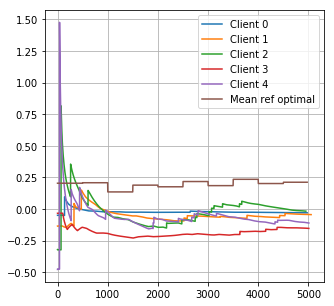

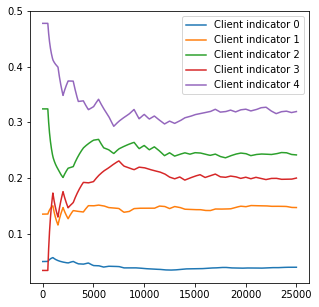

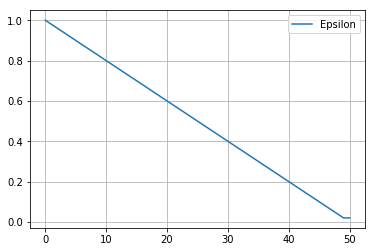

Episode 50 with reward : 0.7847185947326004 and epsilon


In [ ]:

#torch.set_default_tensor_type('torch.cuda.FloatTensor')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Environment.BanditEnvironment_stationary import BanditEnvironment as env_generator
from Tools import Logger
from collections import deque
from keras.utils import to_categorical
import itertools

n_feature_item = 3
n_feature_client = 3
range_price = 100
range_color = 5
n_client = 5
n_item = 5
hidden_layer_size = 64
learning_rate = 5e-2
log_delay = 10
batch_size = 256
target_update = 20
epsilon_decay = 50
catalog_size = 50
input_state_size = catalog_size + 1 + range_color + 1 # ID - price - range_color + UID
GAMMA = 0.99
memory = deque(maxlen = 10000)

class DQN(nn.Module) :
    def __init__(self, gamma) :
        super(DQN, self).__init__()
        self.create_model()
        self.gamma = gamma

    def create_model(self) :
        self.dense1 = nn.Linear(input_state_size, hidden_layer_size)
        self.dense2 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x) :
        client_ID = torch.from_numpy(np.array(x)).float()
        out_1 = torch.relu(self.dense1(client_ID))
        return self.dense2(out_1)

    def remember(self, memory, state, action, next_state, reward, done) :
        memory.append((state, action, next_state, reward, done))

    def sample(self, batch_size, memory) :
        indices = np.random.choice(len(memory), batch_size, replace = False)
        states, actions, next_states, rewards, dones = zip(*[memory[idx] for idx in indices])
        return np.array(states), torch.from_numpy(np.array(actions)), np.array(next_states), np.array(rewards), np.array(dones)

    def choose_action(self, state, epsilon) :

        coin_toss = np.random.random()
        if coin_toss < epsilon :
            return np.random.randint(n_item)
        else :
            user_id = state[0]
            items = state[1]
            scores = []
            for item in items:
                current_state = preprocess(user_id = user_id, items = [item])
                score = self(current_state).item()
                scores.append(score)
            return np.argmax(scores)

    # Return state





class Runner() :
    def __init__(self, env, n_episode = 10000) :
        self.model = DQN(gamma = GAMMA)
        self.target = DQN(gamma = GAMMA)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        #  self.model.cuda()
        self.env = env
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        self.memory = []
        self.gamma = GAMMA
        self.log_delay = log_delay
        self.n_episode = n_episode
        self.batch_size = batch_size
        self.epsilon = np.finfo(np.float32).eps.item()
        self.logger = Logger.Logger(n_client, env, 1000000)
        self.memory_loss = []
        self.epsilon_explo = 1.0
        self.epsilon_origin = 1.0

    def run(self) :
        print(self.model)
        epsilon_log = []
        cumulator = []
        ep_reward = 0
        last_reward = 0
        ep_reward_cumul = []
        mean_delta = []
        mean_log = []
        delay = 500
        for i_episode in range(self.n_episode) :
            client_id, items = self.env.reset()
            ep_reward_cumul.append(ep_reward)
            mean_delta.append(np.mean(cumulator))
            mean_log.append(np.mean(ep_reward_cumul))
            self.epsilon_explo = max(self.epsilon_origin - self.epsilon_origin * i_episode / epsilon_decay, 0.02)
            epsilon_log.append(self.epsilon_explo)
            if i_episode % self.log_delay == 0 :
                clear_output(True)
                self.logger.plot()
                plt.plot(epsilon_log, label = "Epsilon")
                plt.grid()
                plt.legend()
                plt.show()

            ep_reward = 0
            for t in range(delay) :  # Collect trajectoire

                state = [client_id, items]
                action = self.model.choose_action(epsilon = self.epsilon_explo, state = state)
                tmp_for_random = env.current_client
                client_id_next, items, reward = env.step_mono_recommendation(action)
                env.current_client = tmp_for_random
                _, _, reward_random = env.step_mono_recommendation(np.random.randint(n_item))
                env.current_client = client_id_next # Modif temporaire pour comparer le random
                ep_reward += reward
                self.logger.add_reward_client(reward, client_id, reward_random)
                next_state = [client_id_next, items]
                self.model.remember(memory = memory, state = state, next_state = next_state, \
                                    action = action, done = not (t < (delay - 1)), reward = reward)
                client_id = client_id_next
                if t % target_update == 0 :
                    self.target.load_state_dict(self.model.state_dict())
            replay(modele = self.model, target = self.target, optimizer = self.optimizer, memory = memory)
            if i_episode % self.log_delay == 0 :
                print("Episode {} with reward : {} and epsilon".format(i_episode, ep_reward, self.epsilon))


if __name__ == '__main__' :
    env = env_generator(n_client = n_client, n_item = n_item, nb_color = range_color, range_price = range_price)
    runner = Runner(env)
    runner.run()

# TODO :
# Si un utilisateur a eut une bonne recommendation sa "satisfaction augmente" donc plus de chance d'achat, bonus en % sur chance d'achat
# Essayer https://arxiv.org/pdf/1810.12027.pdf

In [ ]:
states, actions, next_states, rewards, dones = runner.model.sample(batch_size, memory)

In [ ]:
print(np.array(states).shape)
states[0]

In [ ]:
res = np.array(process_states(states))#.shape
res.shape, res[0].shape

In [ ]:
res[0, : , :].shape

In [ ]:
test = runner.model(res)
test.shape

In [ ]:
test[0]

In [ ]:
states, actions, next_states, rewards, dones = runner.model.sample(batch_size, memory)
states = process_states(states)
next_states = process_states(next_states)   
rewards = rewards.reshape((-1, 1))

dones = dones.reshape((-1, 1))
prediction = torch.tensor(
    (1 - dones) * (rewards + runner.model.gamma * np.amax(runner.target(next_states).detach().numpy(), axis = 1)))
prediction = prediction.view(-1, 1)
real_value = runner.model(states)
actions = actions.view(-1, 1) # 32, 1
pre = real_value.clone()
for cpt, row in enumerate(real_value):
    row[actions[cpt]] = prediction[cpt].float()
    real_value[cpt] = row
pre[0], real_value[0]

In [ ]:
loss = F.mse_loss(pre, real_value)
loss

In [ ]:
print(real_value[0], prediction[0])
for cpt, row in enumerate(real_value):
   # print(row[actions[cpt]])
   # print(prediction[cpt])
    row[actions[cpt]] = prediction[cpt].float()
    real_value[cpt] = row
print(real_value[0], prediction[0])

In [ ]:
actions.shape, real_value.shape, prediction.shape

In [ ]:
 (1 - dones).shape, \
    np.amax(runner.target(next_states).detach().numpy(), axis = 1).shape,\
    (rewards.reshape((-1, 1)) + runner.model.gamma * np.amax(runner.target(next_states).detach().numpy(), axis = 1)).shape,\
    rewards.reshape((-1, 1)).shape

In [ ]:

real_value[0][1] = 1
real_value[0]